# MarathoNet

_MarathoNet_ es un sistema inteligente capaz de detectar el número de dorsal de corredores de maratón a partir del video extraído de una cámara que graba la carrera en un punto de control.

## Descripción del problema

Para poder identificar el dorsal de un corredor necesitamos detectar en tiempo real dónde se encuentra el cuerpo de éste en cada frame que extraemos de un vídeo que graba la carrera. 

Con el fin de facilitar este trabajo utilizaremos el modelo preentrenado para la detección de cuerpos que ofrece la librería [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose).

## Pruebas iniciales con _Openpose_

Con el fin de familiarizarnos con la librería [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose), disponemos de una serie de vídeos de personas moviéndose en una escena que utilizaremos como toma de contacto inicial con la librería [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) y así observar todas la potencia y funcionalidades que esta ofrece.

### Carga de vídeos

Se procede con la carga de los diferentes archivos de vídeo que disponemos para realizar las prubeas con [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose). Para ello, importaremos el módulo [_os_](https://docs.python.org/3/library/os.html) que permite el manejo de diferentes funcionalidades de sistema operativo, entre ellas, el manejo de ficheros y directorios.

In [1]:
import os

In [2]:
PATH = 'videos'
video_files = list()
for root, dirs, files in os.walk(os.path.relpath(PATH)):
    for file in files:
        video_files.append(os.path.join(root, file))

no_videos = len(video_files)
print(video_files)

['videos/place3-1.mp4', 'videos/place3-2.mp4', 'videos/place3-3.mp4']


El manejo y procesado de videos será gestionado por la librería de visión por computador, [_OpenCV_](https://opencv.org/), que depende a su vez de la archiconocida librería de computación científica, [_Numpy_](https://www.numpy.org/). Mostraremos las imágenes que procesamos [_OpenCV_](https://opencv.org/) en el propio _Jupyter Notebook_, es por este motivo por el cuál también tendremos que importar la librería [Matplotlib](https://matplotlib.org/). A continuación, procederemos con la carga de sendos paquetes:

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

El objeto _VideoCapture_ es el que recibe la entrada de vídeo. Este dispone de una serie de métodos que iremos utilizando a lo largo de las pruebas con Openpose. Se crea un diccionario que contenga un objeto _VideoCapture_ para cada imagen que encontremos en el directorio donde almacenamos los archivos de vídeo.

In [4]:
keys = [ 'video_' + str(i+1) for i in range(len(video_files)) ]

videos = { k: cv.VideoCapture(cv.samples.findFileOrKeep(v)) for (k, v) in zip(keys, video_files) }

for k,v in videos.items():
    if not v.isOpened():
        print('Unable to open: \'' + k + '\'')
        exit(0)

print(videos)

{'video_1': <VideoCapture 0x7f39e6e16c10>, 'video_2': <VideoCapture 0x7f3a342a9470>, 'video_3': <VideoCapture 0x7f39e6e16d90>}


Seleccionaremos un frame arbitrario con el método _set()_ de cada objeto de la clase _VideoCapture_ generado en el paso anterior. El número máximo de frames de un video lo extraemos con el método _get()_ y el selector _cv.CAP_PROP_FRAME_COUNT_ de la clase _VideoCapture_. 

Tomamos un número entero aleatorio dentro del rango de frames que dispone cada vídeo para poder mostrar un frame aleatorio de la misma. Por este motivo tendremos que utilizar el método _randint()_ e importar la librería [random](https://docs.python.org/2/library/random.html).

Posteriormente, recuperamos el frame con el método _read()_ de la misma clase y lo mostraremos por pantalla utilizando el método _plt.imshow()_ de la librería [Matplotlib](https://matplotlib.org/).

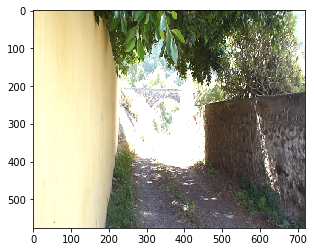

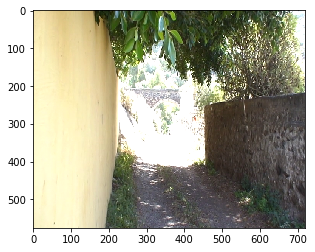

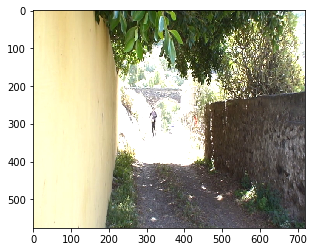

In [5]:
from random import randint

for i in range(no_videos):
    total_frames = videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_COUNT)
    actual_frame = randint(0, total_frames)
    
    videos['video_'+str(i+1)].set(cv.CAP_PROP_POS_FRAMES, actual_frame)
    
    ret, frame = videos['video_'+str(i+1)].read()
    img = cv.cvtColor(frame, cv.COLOR_BGR2RGBA)
    h,w = img.shape[:2]
    
    plt.imshow(img,cmap='gray')
    plt.show()

### Inferencia de puntos clave con _Openpose_

¡Listo! ¡Ya podemos acceder a los frames de un video! El siguiente paso consistirá en procesar las imágenes obtenidas de los videos con _Openpose_ y ver si podemos sacar algunas métricas.

En primer lugar procederemos a cargar las librerías de [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose):

In [6]:
from openpose import pyopenpose as op

#### Configuración inicial del objeto _WrapperPython_

Crearemos una instancia del objeto _WrapperPython_ con el fin de inicializar el modelo preentrenado de [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) y cargar en el mismo los videos con los que hemos estado trabajando con [_OpenCV_](https://opencv.org/). Para ello, crearemos un diccionario de parámetros que pasaremos al constructor de la clase _WrapperPython_.

En primer lugar se carga en el diccionario de parámetros el directorio en donde tenemos almacenado los modelos preentrenados de [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) indicando en la clave del mismo la string _"model_\__folder"_.

Por último, seleccionaremos el parámetro _"face"_ a _True_ para que [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) detecte los puntos clave de la cara. 

In [7]:
params = dict()
params["model_folder"] = "models/"
params["face"] = True

print(params)

{'model_folder': 'models/', 'face': True}


#### Procesado de un vídeo en lote

A continuación, se procede con la carga de ficheros de video para su posterior procesado con [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose). Tendremos que crear una clave en el diccionario de parámetros denominada _"video"_ indicando la ruta a dichos ficheros.

Además, es necesario indicar la ruta en la que queremos almacenar los puntos clave o _keypoints_ de la postura detectada por [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) indicando la ruta en el diccionario de parámetros con la clave _"write_\__json"_.

Es interesante grabar un vídeo con el resultado de las inferencias de [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) y observar visualmente el resultado que obtenemos. La ruta de salvado del vídeo con las inferencias se indican con el parámetro de clave _"video_\__write"_.

In [8]:
params["video"] = video_files[0]
params["write_json"] = "out/json"
params["write_video"] = "out/video/openpose_video.mp4"

print(params)

{'model_folder': 'models/', 'face': True, 'video': 'videos/01_03_03_27_08.mp4', 'write_json': 'out/json', 'write_video': 'out/video/openpose_video.mp4'}


Una vez ajustados todos los parámetros de configuración procederemos a llamar al método _execute()_ de la clase _WrapperPython_ para inicializar el manejador de [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) para que procese el video que hemos seleccionado y devuelva un _JSON_ con los puntos clave inferidos.

In [ ]:
opWrapper = op.WrapperPython()
opWrapper.configure(params)
# opWrapper.execute()
opWrapper.stop()
#del opWrapper

#### Procesado de un vídeo utilizando objetos _Datum_

En el caso anterior, conseguimos inferir los puntos clave de las posturas de personas de un vídeo pasado por parámetro al objeto _WrapperPython_ la ruta de vídeo. En esta sección utilizaremos la funcionalidad de [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) que permite cargar los vídeos programáticamente utilizando el objeto _Datum_. Así que procederemos a crear un objeto de este tipo.

Los parámetros _"video"_ y _"write_\__video"_ serán reseteados, así que procedemos a borrar esos parámetros. 

In [8]:
if "video" in params or "write_video" in params:
    del params["video"]
    del params["write_video"] 

datum = op.Datum()

print(params)

{'model_folder': 'models/', 'face': True}


#### Restaurando el frame inicial de los objetos _VideoCapture_ de _OpenCV_

Como vamos a procesar todo los videos desde el primer al último fotograma tendremos que primero ajustar las propiedades del objeto _VideoCapture_ de cada vídeo para que apunte al primer fotograma y a partir de él empezar a procesar el video fotograma a fotograma con [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose).

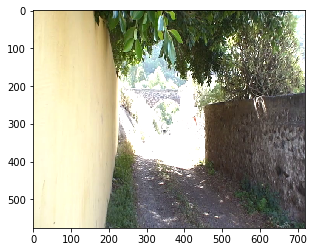

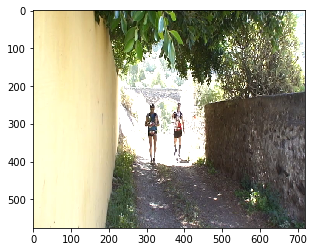

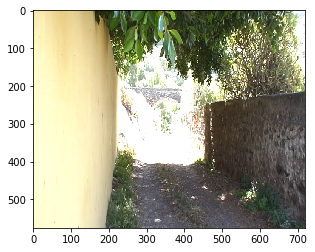

In [9]:
for i in range(no_videos):
    total_frames = videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_COUNT)
    videos['video_'+str(i+1)].set(cv.CAP_PROP_POS_FRAMES, 0)
        
    ret, frame = videos['video_'+str(i+1)].read()
    img = cv.cvtColor(frame, cv.COLOR_BGR2RGBA)
    h,w = img.shape[:2]
    
    plt.imshow(img)
    plt.show()

#### Redimensión de frames de vídeo

Se procederá a implementar una pequeña función que que toma como entrada un frame de vídeo y lo redimensionará, conservando la proporción del mismo, a un tamaño máximo de 800x600 píxeles, siempre y cuando el frame de entrada supere dichas dimensiones. La redimensión de la imagen conlleva una interpolación de área de la imagen resultante (_cv.INTER_\__AREA_).

In [10]:
def define_size(inSize, outSize=(800,600)):
    w, h = inSize
    
    if w > outSize[0]:
        scaling = outSize[0] / w
        w = int(w * scaling)
        h = int(h * scaling)
        
    if h > outSize[1]:
        scaling = outSize[1] / h
        w = int(w * scaling)
        h = int(h * scaling)
        
    return (w, h)

In [11]:
def resize_frame(frame, inSize, outSize=(800,600)):
    dim = define_size(inSize, outSize)
    
    return cv.resize(frame, dim, interpolation=cv.INTER_AREA)

#### Inferencia de posturas con _OpenPose_

Una vez los frames han sido redimensionados se procede con con el proceso de inferencia. Los frames resultantes serán cargados en el objeto _Datum_ y serán procesados desde el manejador _WrapperPython_ de la librería [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose). Se generará, además, un vídeo de salida con el resultado de la inferencia obtenida con [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose).

En esta función se plantea cargar cada fotograma en el objeto _Datum_ que inicializamos anteriormente, asignando a la propiedad _cvInputData_ la imagen a procesar obtenida del objeto _VideoCapture_. Cada vez que invocamos al método _emplaceAndPop()_ de la clase _WrapperPython_ generamos un fichero _JSON_ con el resultado de la inferencia de un fotograma determinado.

El método _start()_ funciona de manera análoga a _execute()_ pero detiene la cola de procesamiento de [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose) permitiendo procesar cada frame paso a paso tras llamar el método _emplaceAndPop()_. El método _stop()_ detiene la ejecución multihilo de que se inicializó con _start()_. Llamaremos a este último método cuando se alcance el último frame del video que se esté procesando.

Utilizando el objeto _VideoWriter_ de [_OpenCV_](https://opencv.org/) podremos generar un video con el resultado de la inferencia. Se deberá pasar por parámetro la ruta en la cual se desea guardar el vídeo con los resultados finales.

In [12]:
def infere(i, file_i, opWrapper, datum, videos, size=(800,600)):
    total_frames = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_COUNT))
    w = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_WIDTH))
    h = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FPS))
    
    videos['video_'+str(i+1)].set(cv.CAP_PROP_POS_FRAMES, 0)
    
    wVideo = cv.VideoWriter(OUT_PATH + "video/" + file_i + "/" + file_i + ".mp4", 
                            cv.VideoWriter_fourcc(*'H264'), fps, define_size((w,h), size))
    
    for j in range(total_frames):
        ret, frame = videos['video_'+str(i+1)].read()
        datum.cvInputData = resize_frame(frame, (w,h), size)
        
        opWrapper.emplaceAndPop([datum])
        datum.id = j
        datum.name = f'openpose_{file_i}_{datum.id:09}'
        
        
        wVideo.write(datum.cvOutputData)
    wVideo.release()
    opWrapper.stop()

#### Generando resultados

Se plantea un bucle en el que en cada iteración se configuran los parámetros del objeto _WrapperPython_ con el fin de guardar el fichero _JSON_ con las inferencias de los puntos clave en una carpeta única para cada video que se procese.

Cada vídeo es procesado con la función _infere()_ que creamos anteriormente. El resultado de la inferencia lo cargaremos en una carpeta llamada _\[Fecha\]_\__openpose_, donde _Fecha_ es la fecha actual. 

Dentro de esta carpeta encontraremos el directorio que contiene los archivos _JSON_ con el resultado de la inferencia y otro directorio con los vídeos que muestran visualmente los resultados con [_Openpose_](https://github.com/CMU-Perceptual-Computing-Lab/openpose).

In [ ]:
from datetime import date

today = date.today()
d1 = today.strftime("%d.%m.%Y")

OUT_PATH = "out/openpose_" + d1 + "/"

if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

for i, file_i in enumerate(video_files):
    file_i = os.path.splitext(os.path.split(file_i)[1])[0]
    
    if not os.path.exists(OUT_PATH + "video/"):
        os.mkdir(OUT_PATH + "video/")
        
    if not os.path.exists(OUT_PATH + "json/"):
        os.mkdir(OUT_PATH + "json/")
    
    if not os.path.exists(OUT_PATH + "video/" + file_i):
        os.mkdir(OUT_PATH + "video/" + file_i)
    
    if not os.path.exists(OUT_PATH +"json/" + file_i):
        os.mkdir(OUT_PATH + "json/" + file_i)
    
    opWrapper = op.WrapperPython()
    
    params["write_json"] = OUT_PATH + "json/" + file_i
    
    opWrapper.configure(params)
    opWrapper.start()
    
    opWrapper.configure(params)
    
    infere(i, file_i, opWrapper, datum, videos, (800, 600))